In [1]:
import numpy as np
import pandas as pd
import os
import sys
import xgboost as xg
#sys.path.insert(0,'content/data')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# We're going to use "listings"
data = pd.read_csv("drive/MyDrive/ML/bnb_data/listings.csv", engine = 'python')
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,2015,2695,3176,3309,7071,9991,14325,16401,16644,17409
name,Berlin-Mitte Value! Quiet courtyard/very central,Prenzlauer Berg close to Mauerpark,Fabulous Flat in great Location,BerlinSpot Schöneberg near KaDeWe,BrightRoom with sunny greenview!,Geourgeous flat - outstanding views,Apartment in Prenzlauer Berg,APARTMENT TO RENT,In the Heart of Berlin - Kreuzberg,Downtown Above The Roofs In Berlin
host_id,2217,2986,3718,4108,17391,33852,55531,59666,64696,67590
host_name,Ian,Michael,Britta,Jana,Bright,Philipp,Chris + Oliver,Melanie,Rene,Wolfram
neighbourhood_group,Mitte,Pankow,Pankow,Tempelhof - Schöneberg,Pankow,Pankow,Pankow,Friedrichshain-Kreuzberg,Friedrichshain-Kreuzberg,Pankow
neighbourhood,Brunnenstr. Süd,Prenzlauer Berg Nordwest,Prenzlauer Berg Südwest,Schöneberg-Nord,Helmholtzplatz,Prenzlauer Berg Südwest,Prenzlauer Berg Nordwest,Frankfurter Allee Süd FK,nördliche Luisenstadt,Prenzlauer Berg Südwest
latitude,52.534537,52.548513,52.534996,52.498855,52.543157,52.533031,52.547846,52.510514,52.504792,52.529071
longitude,13.402557,13.404553,13.417579,13.349065,13.415091,13.416047,13.405562,13.45785,13.435102,13.412843
room_type,Entire home/apt,Private room,Entire home/apt,Private room,Private room,Entire home/apt,Entire home/apt,Private room,Entire home/apt,Private room
price,60,17,90,26,42,180,70,120,90,45


In [3]:
# Let's remove some columns
data = data.drop("id", axis = 1)
data = data.drop("name", axis = 1)
data = data.drop("host_id", axis = 1)
data = data.drop("host_name", axis = 1)
data = data.drop("neighbourhood_group", axis = 1)
data = data.drop("neighbourhood", axis = 1)
data = data.drop("last_review", axis = 1)
# data = data.drop("minimum_nights", axis = 1)
# data = data.drop("reviews_per_month", axis = 1)
# data = data.drop("availability_365", axis = 1)
# data = data.drop("room_type", axis = 1)

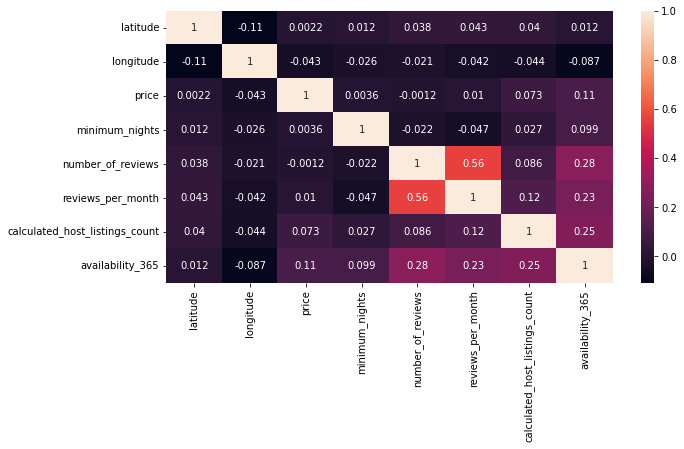

In [4]:
# Visualizing the correlation matrix
corrMatrix = data.corr()
fig = plt.figure(figsize=(10,5))
sns.heatmap(corrMatrix, annot=True)

In [5]:
# Removing columns that have lower impact on the price
data = data.drop("number_of_reviews", axis = 1)
data = data.drop("minimum_nights", axis = 1)
# data = data.drop("latitude", axis = 1)
# data = data.drop("longitude", axis = 1)

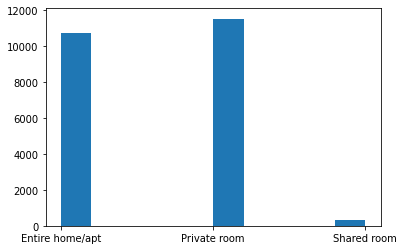

In [6]:
# Substituting "Entire home/apt", "Private room" and "Shared room" with their frequencies.
plt.hist(data.room_type)
apt_freq = np.array(data.room_type.value_counts())/data.shape[0]
data.room_type.replace(["Private room", "Entire home/apt", "Shared room"], apt_freq, inplace = True)

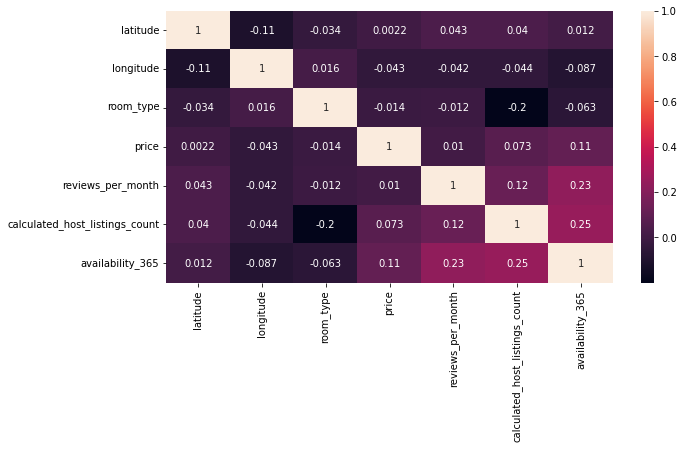

In [7]:
# Visualizing the correlation matrix
corrMatrix = data.corr()
fig = plt.figure(figsize=(10,5))
sns.heatmap(corrMatrix, annot=True)

In [8]:
# Removing "room_type" that have lower impact on the price and on the 
# availability_365 which is the variable with the maximum correlation with the
# price
data = data.drop("room_type", axis = 1)

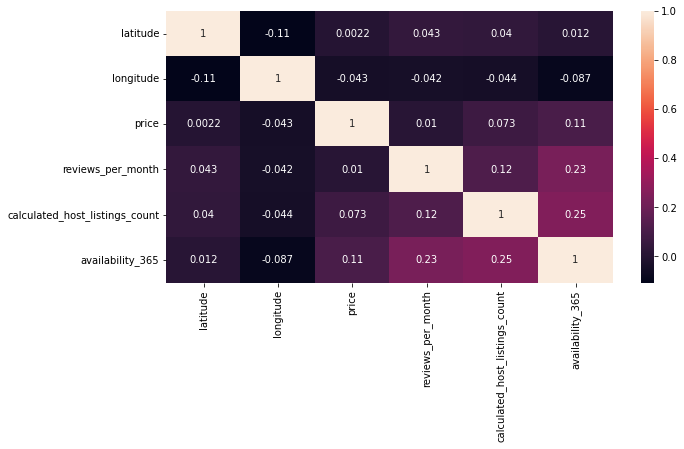

In [9]:
# Visualizing the correlation matrix
corrMatrix = data.corr()
fig = plt.figure(figsize=(10,5))
sns.heatmap(corrMatrix, annot=True)

In [10]:
# Create a new column forming a distance using longitude and latitude
data["distance"] = np.sqrt(data["latitude"]**2 + data["longitude"]**2)

In [11]:
# Removing latitude and longitute now that we have the distance column
data = data.drop("latitude", axis = 1)
data = data.drop("longitude", axis = 1)

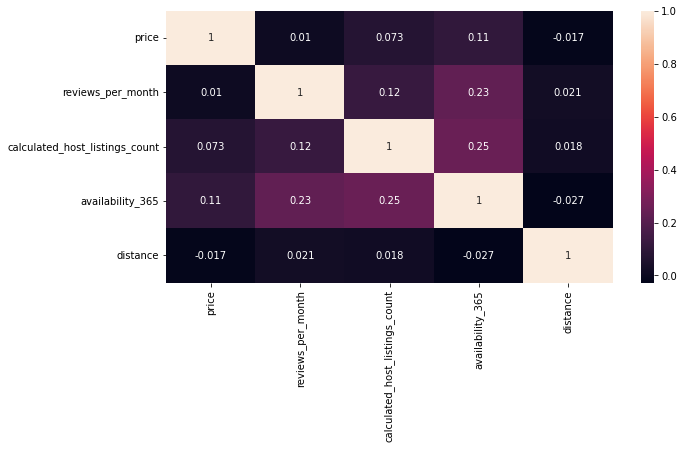

In [12]:
# Visualizing the correlation matrix
corrMatrix = data.corr()
fig = plt.figure(figsize=(10,5))
sns.heatmap(corrMatrix, annot=True)

In [13]:
# Replacing NaN entires with "0"
data.fillna(0, inplace = True)

In [14]:
# Let's remove all 0 prices, since there are only 8 entries with 0 price
print("Number of entires with 0 price: ", data[data.price == 0].shape[0])
data = data.drop(data[data.price == 0].index)

Number of entires with 0 price:  8


(0.0, 500.0)

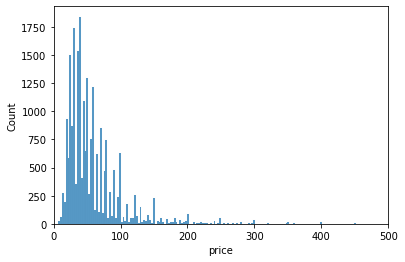

In [15]:
# Plotting histogram to understand the distribution.
# sns.kdeplot(data['price'])
sns.histplot(data['price'])
plt.xlim(-0,500)
# plt.xscale('log')

In [16]:
# Let's sort values by the 
data_perc = data.sort_values(by = 'price', inplace = False)
nperc = 15 # number of percentiles
data_perc['PercentileRank']= pd.qcut(data_perc['price'],
                             q = nperc, labels = False)

In [17]:
data_perc

,price,reviews_per_month,calculated_host_listings_count,availability_365,distance,PercentileRank
17054,1,9.32,1,5,54.199855,0
1651,8,0.02,1,0,54.205389,0
16153,8,1.49,1,0,54.128094,0
10854,8,1.95,4,0,54.186847,0
18548,8,5.30,4,0,54.187598,0
...,...,...,...,...,...,...
19372,6000,1.53,10,361,54.156345,14
19662,6000,0.81,10,361,54.167048,14
15665,8000,1.11,2,7,54.165308,14
21389,8600,0.81,1,174,54.214772,14


In [18]:
# Selecting rows in data with a condition on the 'price'
mae_t = 0
rmse_t = 0
for i in np.arange(nperc):
  dataf = data_perc[data_perc['PercentileRank'] == i]
  dataf = dataf.drop('PercentileRank', axis = 1)
  # Dataset preparation
  X = dataf.drop("price", axis = 1).values
  y = dataf.price.values

  #splitting Train and Test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
  #standardization scaler - fit&transform on train, fit only on test
  s_scaler = StandardScaler()
  X_train = s_scaler.fit_transform(X_train.astype(float))
  X_test = s_scaler.transform(X_test.astype(float))

  # Multiple Linear Regression
  regressor = LinearRegression()
  regressor.fit(X_train, y_train)
  # predicting the test set result
  y_pred_LR = regressor.predict(X_test)

  mae_p = metrics.mean_absolute_error(y_test, y_pred_LR)
  rmse_p = np.sqrt(metrics.mean_squared_error(y_test, y_pred_LR))
  mae_t += mae_p
  rmse_t += rmse_p

  # print(f"\nMean absolute error for {i + 1} percentile is: {mae_p}")
  # print(f"\nRoot of the mean squared error for {i + 1} percentile is: {rmse_p}")
  # compare actual output values with predicted values

  df_LR = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_LR})
  print(df_LR.head(5))
print("\nRoot of the mean squared error divided by the number of percentiles:", rmse_t/nperc)
print("\nMean absolute error divided by the number of percentiles:", mae_t/nperc)

   Actual  Predicted
0      21  16.675558
1      19  17.863063
2      20  18.159566
3      20  17.849736
4      20  17.856442
   Actual  Predicted
0      25  24.214486
1      22  24.106028
2      25  24.203626
3      25  24.246871
4      25  24.166983
   Actual  Predicted
0      28  29.088083
1      28  28.980614
2      30  29.086563
3      27  29.048993
4      30  29.086175
   Actual  Predicted
0      32  31.732036
1      32  31.679504
2      32  31.796190
3      32  31.683618
4      32  31.695001
   Actual  Predicted
0      35  34.694373
1      35  34.676894
2      35  34.655888
3      35  34.686583
4      35  34.672393
   Actual  Predicted
0      38  39.183447
1      40  39.212984
2      40  39.198447
3      36  39.139593
4      40  39.209472
   Actual  Predicted
0      41  44.135477
1      45  44.135727
2      45  44.101300
3      45  44.176372
4      42  44.209048
   Actual  Predicted
0      49  48.142224
1      49  48.107893
2      47  48.164982
3      49  48.155139
4      47  48

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-300.0, 1000.0)

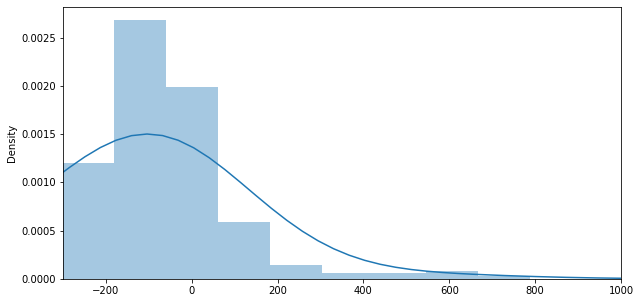

In [19]:
# visualizing residuals
# by visualizing the residual we can see that is normally distributed (proof of having linear relationship with the dependent variable)
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred_LR)
sns.distplot(residuals)
plt.xlim(-300, 1000)

### XGBoost

In [27]:
# We first test XGBoost without dividing the dataset into percentiles
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 123)

# Dataset preparation
X = data.drop("price", axis = 1).values
y = data.price.values

#splitting Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
#standardization scaler - fit&transform on train, fit only on test
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(float))
X_test = s_scaler.transform(X_test.astype(float))

# Fitting the model
xgb_r.fit(X_train, y_train)

# Predict the model
pred = xgb_r.predict(X_test)
  
# RMSE Computation
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  98.173772


In [29]:
# Now, let's see how it works with percentiles

# Selecting rows in data with a condition on the 'price'
mae_t = 0
rmse_t = 0
for i in np.arange(nperc):
  dataf = data_perc[data_perc['PercentileRank'] == i]
  dataf = dataf.drop('PercentileRank', axis = 1)
  # Dataset preparation
  X = dataf.drop("price", axis = 1).values
  y = dataf.price.values

  #splitting Train and Test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
  #standardization scaler - fit&transform on train, fit only on test
  s_scaler = StandardScaler()
  X_train = s_scaler.fit_transform(X_train.astype(float))
  X_test = s_scaler.transform(X_test.astype(float))

  # Fitting the model
  xgb_r.fit(X_train, y_train)

  # Predict the model
  y_pred_xg = xgb_r.predict(X_test)

  mae_p = metrics.mean_absolute_error(y_test, y_pred_xg)
  rmse_p = np.sqrt(metrics.mean_squared_error(y_test, y_pred_xg))
  mae_t += mae_p
  rmse_t += rmse_p

  # print(f"\nMean absolute error for {i + 1} percentile is: {mae_p}")
  # print(f"\nRoot of the mean squared error for {i + 1} percentile is: {rmse_p}")
  # compare actual output values with predicted values

  df_LR = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_xg})
  print(df_LR.head(5))
print("\nRoot of the mean squared error divided by the number of percentiles:", rmse_t/nperc)
print("\nMean absolute error divided by the number of percentiles:", mae_t/nperc)

   Actual  Predicted
0      21  16.271561
1      19  18.303036
2      20  18.429302
3      20  17.359470
4      20  17.938972
   Actual  Predicted
0      25  24.353275
1      22  24.470160
2      25  24.168016
3      25  24.462278
4      25  24.211245
   Actual  Predicted
0      28  29.374624
1      28  28.751987
2      30  29.243994
3      27  28.971786
4      30  29.081781
   Actual  Predicted
0      32  31.767288
1      32  31.718576
2      32  31.854698
3      32  31.639370
4      32  31.671204
   Actual  Predicted
0      35  34.593208
1      35  34.857273
2      35  34.736095
3      35  34.597374
4      35  34.749966
   Actual  Predicted
0      38  39.547768
1      40  39.198666
2      40  39.173019
3      36  39.405148
4      40  39.080364
   Actual  Predicted
0      41  44.157028
1      45  44.157028
2      45  44.002190
3      45  44.120159
4      42  44.081795
   Actual  Predicted
0      49  48.073814
1      49  48.027493
2      47  47.870987
3      49  48.389362
4      47  48

In [ ]:
# Ahora, modelemos con las redes neuronales
# https://towardsai.net/p/deep-learning/house-price-predictions-using-keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Dropout
from keras.layers import LeakyReLU
import tensorflow as tf

In [ ]:
model = Sequential()
model.add(Dense(15, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(50, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(15, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(50, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=10*0.001), loss = 'mse')

In [ ]:
# Selecting rows in data with a condition on the 'price'
error = 0
for i in np.arange(nperc):
  dataf = data[data['PercentileRank'] == i]
  dataf = dataf.drop('PercentileRank', axis = 1)
  # Dataset preparation
  X = dataf.drop("price", axis = 1).values
  y = dataf.price.values

  #splitting Train and Test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
  #standardization scaler - fit&transform on train, fit only on test
  s_scaler = StandardScaler()
  X_train = s_scaler.fit_transform(X_train.astype(float))
  X_test = s_scaler.transform(X_test.astype(float))

  model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), batch_size = X_train.shape[0], epochs = 300);

  loss_df = pd.DataFrame(model.history.history)
  loss_df.plot(figsize = (12,8))
  # predicting the test set result
  # y_pred_LR = regressor.predict(X_test)
  # evaluate the preformance of the algorithm (MAE - MSE - RMSE)
  # print("Mean absolute error:", metrics.mean_absolute_error(y_test, y_pred_LR)) 
# print("Mean squared error:", metrics.mean_squared_error(y_test, y_pred_LR))
  # print("Root of the mean squared error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_LR)))
  # error += np.sqrt(metrics.mean_squared_error(y_test, y_pred_LR))
  # print(f"Root of the mean squared error {i + 1} is: {np.sqrt(metrics.mean_squared_error(y_test, y_pred_LR))}")
  # compare actual output values with predicted values
  # df_LR = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_LR})
  # print(df_LR.head(5))
# print("\nRoot of the mean squared error divided by the number of percentiles:", error/nperc)

In [ ]:
model = Sequential()
model.add(Dense(15, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(50, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(15, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(50, activation = 'relu'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=10*0.001), loss = 'mse')

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 118396.3359 - val_loss: 164644.9688
Epoch 2/500
1/1 [==============================] - 0s 38ms/step - loss: 118347.4531 - val_loss: 164581.6250
Epoch 3/500
1/1 [==============================] - 0s 37ms/step - loss: 118288.8516 - val_loss: 164487.3750
Epoch 4/500
1/1 [==============================] - 0s 32ms/step - loss: 118201.3750 - val_loss: 164357.5469
Epoch 5/500
1/1 [==============================] - 0s 34ms/step - loss: 118080.5547 - val_loss: 164183.0156
Epoch 6/500
1/1 [==============================] - 0s 37ms/step - loss: 117918.0938 - val_loss: 163949.3281
Epoch 7/500
1/1 [==============================] - 0s 32ms/step - loss: 117700.2891 - val_loss: 163640.1094
Epoch 8/500
1/1 [==============================] - 0s 32ms/step - loss: 117411.6953 - val_loss: 163237.5000
Epoch 9/500
1/1 [==============================] - 0s 35ms/step - loss: 117036.0000 - val_loss: 162721.6406
Epoch 10/500
1/1 [============

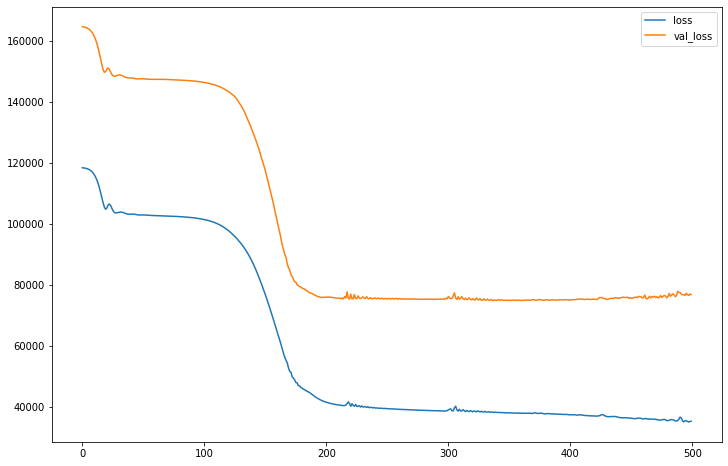

In [ ]:
model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), batch_size = X_train.shape[0], epochs = 300)

loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize = (12,8))

Mean absolute error: 10.638087856235789
Root of mean squared error: 12.667483265997662
Mean absolute percentage error: 15.251225967182938 %


(50.0, 100.0)

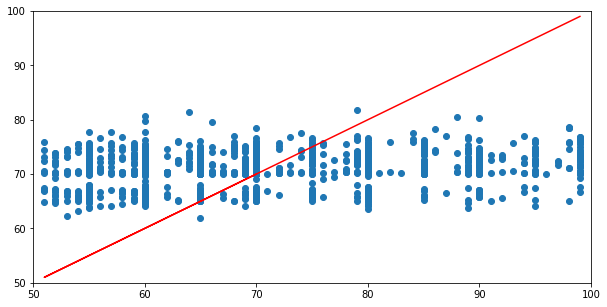

In [ ]:
y_pred = model.predict(X_test)

from sklearn import metrics

print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))

# print('Mean squared error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root of mean squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# print('VarScore:', metrics.explained_variance_score(y_test, y_pred))
print("Mean absolute percentage error:", metrics.mean_absolute_percentage_error(y_test, y_pred)*100, "%")

# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)

# Perfect predictions
plt.plot(y_test,y_test,'r')
plt.xlim(50, 100)
plt.ylim(50, 100)

In [ ]:
# NN predición
df_nn = pd.DataFrame({"Actual": y_test, "Predicted": y_pred.ravel()})
df_nn.head(10)

,Actual,Predicted
0,99,74.147255
1,75,70.658600
2,54,76.754807
3,55,74.971535
4,70,74.699135
5,76,71.623734
6,95,75.980270
7,85,71.978851
8,67,70.476845
9,55,77.360855


In [ ]:
# NN predición
df_nn = pd.DataFrame({"Actual": y_test, "Predicted": y_pred.ravel()})
df_nn.head(10)

,Actual,Predicted
0,99,74.147255
1,75,70.658600
2,54,76.754807
3,55,74.971535
4,70,74.699135
5,76,71.623734
6,95,75.980270
7,85,71.978851
8,67,70.476845
9,55,77.360855


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


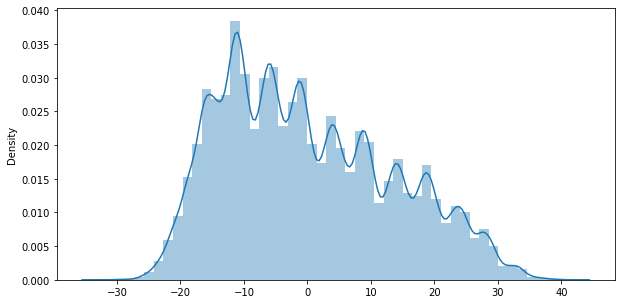

In [ ]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred)
sns.distplot(residuals)

In [ ]:
#listings = pd.read_csv("data/listings.csv", engine = 'python')
#listings_summary = pd.read_csv("data/listings_summary.csv", engine = 'python', error_bad_lines=False)
#neighbourhoods = pd.read_csv("data/neighbourhoods.csv", engine = 'python')
#calendar_summary = pd.read_csv("data/neighbourhoods.csv", engine = 'python')
#reviews = pd.read_csv("data/reviews.csv", engine = 'python')
#reviews_summary = pd.read_csv("data/reviews_summary.csv", engine = 'python', error_bad_lines=False)

In [ ]:
#visualizing house prices
#fig = plt.figure(figsize = (10,7)) 
#fig.add_subplot(2, 1, 1)
#sns.distplot(data['price'])
#fig.add_subplot(2, 1, 2)
#sns.boxplot(data['price'])
#plt.tight_layout()

In [ ]:
# #visualizing the price dependence on the number of reviews, latitute and logitude
# fig = plt.figure(figsize = (16, 5))
# fig.add_subplot(2, 2, 1)
# sns.scatterplot(data['price'], data['number_of_reviews'])
# fig = plt.figure(figsize = (16, 5))
# fig.add_subplot(2, 2, 2)
# sns.scatterplot(data['price'], data['latitude'])
# fig = plt.figure(figsize = (16, 5))
# fig.add_subplot(2, 2, 3)
# sns.scatterplot(data['price'], data['longitude'])

In [ ]:
# fig = plt.figure(figsize = (16, 16))
# fig.add_subplot(2, 3, 1)
# sns.jointplot(x ='price', y ='latitude', data = data, kind ='kde')